# Fundamental-based Universe Screening


In [1]:
import logging, os, pickle
import requests, glob
from datetime import datetime
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import time
from datetime import date
import urllib.request
from selenium.webdriver import Chrome
import json, re, sys, h5py
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
import datetime as dt
import pymysql
import matplotlib.pyplot as plt
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from pykrx import stock
import warnings
warnings.filterwarnings(action='ignore')
import shutil
from matplotlib.pyplot import cm
import numpy as np
import scipy.stats as stats
from scipy import stats
import pyautogui
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.linear_model import LinearRegression
import matplotlib.font_manager as fm
import sys
import seaborn as sns
%matplotlib inline
plt.rcParams['font.family'] = 'NanumSquare_ac'
sys.path.append('C:\\Users\Bae Kyungmo\OneDrive\Desktop\StockTraidingAutomation\DataModeling')
from Loader_v2 import Loader
ldr = Loader(pwd='tlqkfdk2')

In [117]:
#font_list = [font.name for font in fm.fontManager.ttflist]
# font_path = r'C:\Users\Bae Kyungmo\Downloads\Nanumsquare_ac_TTF\Nanumsquare_ac_TTF\NanumSquare_acR.ttf'
# fontprop = fm.FontProperties(fname=font_path, size=15)

---

### Definition of a stock's 'Goodness'

1) High Cumulative Return : mathematically it can be summarized as ln(P_last) - ln(P_start). <br>
2) Geometric Mean of Return : it means how much average return would be realized. <br>
2-1) Mean of Positive Return <br>
3) Ratio of Positive Return : likewise hit-ratio just count the frequency of returns that go up.  <br>
3-1) Maximum Return <br>
4) Maximum Draw Down <br>

In [200]:
def HCR(start, end, code_ls):
    pr = ldr.GetPricelv2(start, end, code_ls)
    log_pr = np.log(pr)
    meanHCR = log_pr[log_pr.index.isin([log_pr.index[0],log_pr.index[-1]])].diff(1).iloc[-1,:].mean()
    return meanHCR+1

In [263]:
def MPR(start, end, code_ls):
    pr = ldr.GetPricelv2(start, end, code_ls)
    pr = pr.pct_change().astype(float)
    mpr_ls = []
    for cd in pr.columns :
        mpr_ls.append(pr[lambda x : x[cd]>=0][cd].mean())
    return sum(mpr_ls) / len(mpr_ls)

In [ ]:
def MR(start, end, code_ls):
    pr = ldr.GetPricelv2(start, end, code_ls)
    pr = pr.pct_change().astype(float)
    mr_ls = []
    for cd in pr.columns:
        mr_ls.append(pr[])

In [284]:
qwe.pct_change().describe()

,005930
count,1211.000000
mean,0.001100
std,0.017262
min,-0.080357
25%,-0.009012
50%,0.001086
75%,0.011208
max,0.104706


In [ ]:
drop_ls = []
for cd in log_pr.columns:
    if len(log_pr[cd].value_counts())==1:
        drop_ls.append(cd)
    elif log_pr[cd].value_counts().iloc[:2].sum() >= len(log_pr[cd]) * 0.3 :
        drop_ls.append(cd)

<AxesSubplot:>

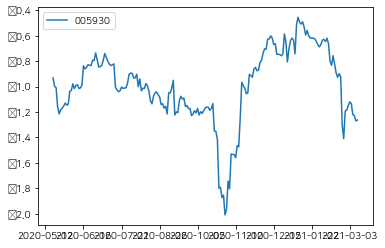

In [279]:
qwe.pct_change().rolling(30).apply(lambda x: (x.mean() - 0.02) / x.std(), raw = True).plot()

In [280]:
qwe = ldr.GetPricelv2('2016-04-01','2021-03-10',['005930'])

<AxesSubplot:>

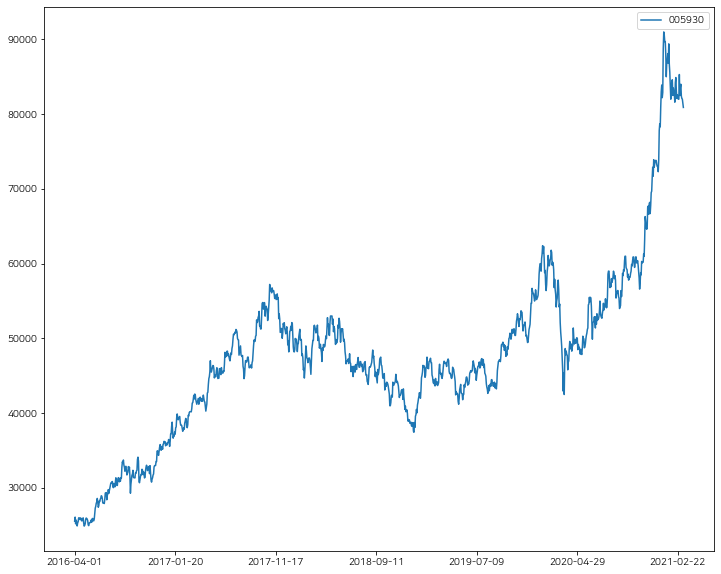

In [281]:
qwe.plot(figsize=(12,10))

In [270]:
qwe.describe()

,005930
count,231.000000
mean,62841.125541
std,12699.292912
min,45800.000000
25%,53150.000000
50%,58600.000000
75%,72950.000000
max,91000.000000


---

### Phase1) Basic Funda Analysis

* 주식 투자 관련 공부를 좀 해본 사람들이라면 PBR이 낮을수록 저평가된 주식으로 예후가 좋을 것이라고들 예상한다.
* 실제로 PBR을 1 기준으로 나누어 향후 평균적인 누적수익률을 계산해보면 저PBR 그룹에서 더 예후가 좋다.
* 그러나 Sector별로 보편적인 재무제표의 분포가 다르고 그에 따라 Median(PBR)로 그룹을 나누어 비교해보면 모든 Sector에서 그렇지 않다.
* 이런 Simpson's Paradox 현상을 인지하고 그에 맞게 더 세분화하여 Universe를 구성하여야 투자의 정보로써 가치가 있다.

In [257]:
len(PBR2019[PBR2019['PBR']>=PBR2019['PBR'].median()]) / len(PBR2019)

0.5002421307506053

In [255]:
len(PBR2019[PBR2019['PBR']>=1]) / len(PBR2019)

0.5486682808716707

PBR이 1보다 큰 종목들은 전체에서 54%정도를 차지하고 있다.

In [233]:
def RatioCheckBySector(df,fd='PBR',byValue='one'):
    sectors = list(set(df['sector'].values))
    rst = pd.DataFrame(columns=['OverRatio'],index=sectors)
    ratio = []
    if byValue=='one':
        byValue=1
    elif byValue=='median':
        byValue=df[fd].median()
    else :
        raise ValueError("Not Available")
    for sc in sectors:
        sub = df[(df.sector==sc)]
        t_nb = len(sub)
        h_nb = len(sub[sub[fd]>=byValue])
        rst.loc[sc,'OverRatio'] = h_nb / t_nb
    rst['OverRatio'] = rst['OverRatio'].astype(float) 
    return rst

In [249]:
RatioCheckBySector(PBR2019,'PBR','one').tail()

,OverRatio
자동차 신품 부품 제조업,0.215909
신발 및 신발 부분품 제조업,1.000000
생활용품 도매업,0.470588
기타 식품 제조업,0.620690
의약품 제조업,0.790123


In [250]:
RatioCheckBySector(PBR2019,'PBR','median').tail()

,OverRatio
자동차 신품 부품 제조업,0.181818
신발 및 신발 부분품 제조업,1.000000
생활용품 도매업,0.470588
기타 식품 제조업,0.620690
의약품 제조업,0.753086


PBR이 1이나 전체 PBR의 Median보다 큰 비율을 계산해보면 Sector별로 구성이 다른 것을 확인할 수 있다.

In [24]:
PBR2019 = ldr.GetFunda('2019-12',itm=['PBR'],level=2)

In [19]:
comp = ldr.CompanyInfo()[['code','sector']]
comp.index = comp.code
comp.drop(['code'],axis=1,inplace=True)
code_to_sector = comp.to_dict()['sector']

In [208]:
whole_low = PBR2019[lambda x : x['PBR']<PBR2019['PBR'].median()].index.to_list()
whole_high = PBR2019[lambda x : x['PBR']>=PBR2019['PBR'].median()].index.to_list()

In [221]:
whole = pd.DataFrame(columns=['hcr_low_fd','hcr_high_fd'],index=['PBR'])
whole['hcr_low_fd'] = [HCR('2020-04-01','2021-03-10',whole_low)]
whole['hcr_high_fd'] = [HCR('2020-04-01','2021-03-10',whole_high)]

<AxesSubplot:>

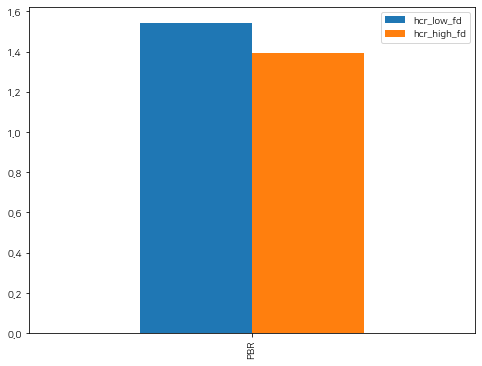

In [223]:
whole.plot(kind='bar', figsize=(8,6))

이것만 보면 저PBR이 기대주가 되어 저PBR로 포트폴리오를 구성해야 할 것 같지만 한 번 Sector별로 Median 그룹별 누적수익률의 예후를 확인해보자

In [26]:
PBR2019['sector'] = PBR2019.index.map(code_to_sector)
PBR2019.dropna(axis=0,inplace=True)
PBR2019['PBR'] = PBR2019['PBR'].astype(float)
PBR2019_median = PBR2019.groupby(['sector']).median()

In [136]:
def BarPlot(df, fd_nm='PBR', TOP_N=10):
    TOP_N_sectors = list(ldr.CompanyInfo()['sector'].value_counts().index[:TOP_N])
    sub = df[df.index.isin(TOP_N_sectors)]
    idx = np.arange(len(sub.index.to_list()))
    plt.figure(figsize=(12,10))
    plt.bar(sub.index.to_list(), sub[fd_nm].values, color='red', alpha=0.4)
    plt.title('Bar Plot of {} by Sector'.format(fd_nm), fontsize=18,fontproperties=fontprop)
    plt.xlabel('SOME SECTORS', fontsize=15,fontproperties=fontprop)
    plt.ylabel(fd_nm, fontsize=15,fontproperties=fontprop)
    plt.xticks(idx, sub.index.to_list(), fontsize=10,fontproperties=fontprop,rotation=300)
    plt.show()
    return True

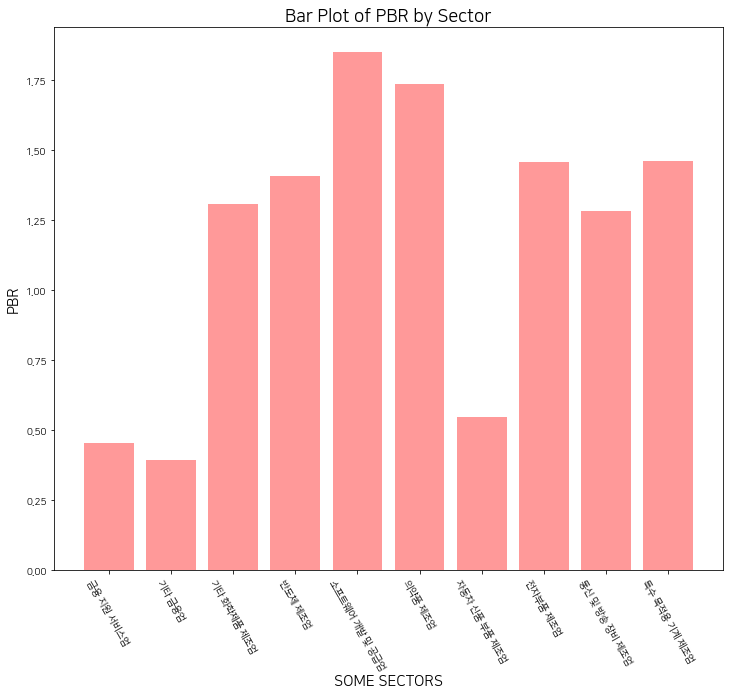

True

In [142]:
BarPlot(PBR2019_median)

일단 PBR자체에 대한 중앙값이 Sector별로 큰 차이가 난다.

In [201]:
low_fd = []
high_fd = []
for sc in TOP_N_sectors:
    sc_low = PBR2019[(PBR2019.sector==sc)&(PBR2019.PBR<PBR2019_median.loc[sc,'PBR'])].index.to_list()
    sc_high = PBR2019[(PBR2019.sector==sc)&(PBR2019.PBR>=PBR2019_median.loc[sc,'PBR'])].index.to_list()
    hcr_low = HCR('2020-04-01','2021-03-10',sc_low)
    hcr_high = HCR('2020-04-01','2021-03-10',sc_high)
    low_fd.append(hcr_low)
    high_fd.append(hcr_high)

In [202]:
total = pd.DataFrame(index=TOP_N_sectors, columns=['hcr_low_fd','hcr_high_fd'])
total['hcr_low_fd'] = low_fd
total['hcr_high_fd'] = high_fd

<AxesSubplot:>

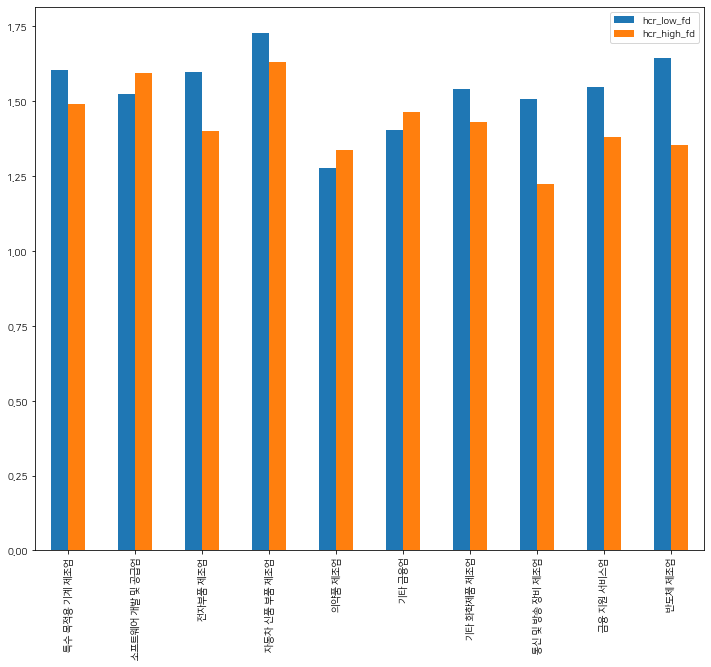

In [203]:
total.plot(kind='bar',figsize=(12,10))

종목들의 수가 많은 10개의 Sector에 대해서만 해봐도 '소프트웨어','의약품','금융업' 등에서는 고PBR이 저PBR보다 평균적인 누적수익률의 예후가 좋았다.

---

In [ ]:
def BarPlotHCR(df fd_nm='PBR', TOP_N=10):
    low_fd = []
    high_fd = []
    for sc in TOP_N_sectors:
        sc_low = PBR2019[(PBR2019.sector==sc)&(PBR2019.PBR<PBR2019_median.loc[sc,'PBR'])].index.to_list()
        sc_high = PBR2019[(PBR2019.sector==sc)&(PBR2019.PBR>=PBR2019_median.loc[sc,'PBR'])].index.to_list()
        hcr_low = HCR('2020-04-01','2021-03-10',sc_low)
        hcr_high = HCR('2020-04-01','2021-03-10',sc_high)
        low_fd.append(hcr_low)
        high_fd.append(hcr_high)
    total = pd.DataFrame(index=TOP_N_sectors, columns=['hcr_low_fd','hcr_high_fd'])
    total['hcr_low_fd'] = low_fd
    total['hcr_high_fd'] = high_fd
    total.plot(kind='bar',figsize=(12,10))
    return True